# Lab 5

This lab extends binary logistic regression to [multi-class logistic regression](https://en.wikipedia.org/wiki/Multinomial_logistic_regression), which goes by a variety of names, including *softmax regression*, due to the use of the softmax function, which generalizes the logistic function.

In [2]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

We again load the Fashion MNIST dataset, though this time around, we'll use all 10 output classes.

In [3]:
from keras.datasets import fashion_mnist

# Load the Fashion MNIST dataset.
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
X_train = X_train / 255
X_test = X_test / 255

# Flatten Y_train and Y_test, so they become vectors of label values.
# The label for X_train[0] is in Y_train[0].
Y_train = Y_train.flatten()
Y_test = Y_test.flatten()

label_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train = X_train[shuffled_indices]
Y_train = Y_train[shuffled_indices]

### Cross-Entropy Loss

Recall the log loss function (also called binary cross-entropy):

\begin{equation}
-y log(\hat{y}) + (1−y)log(1−\hat{y})
\end{equation}

In the above formulation, it is assumed that $y$ is either 0 or 1, so either the left term or the right term is active for each example.

The general form for cross-entropy is used when $y$ is assumed to be a label vector with a 1 in the index of the true label and a 0 everywhere else: $y=[0,0,0,0,0,0,0,1,0,0]$ implies a label of "sneaker" in this dataset (the 7th label). Accordingly, $\hat{y}$ is a vector of predicted probabilities. Then the cross-entropy loss is simply:

\begin{equation}
-\sum_{j} y_j log(\hat{y}_j)
\end{equation}

As in the binary case, this summation will have exactly 1 non-zero term where the true label $y_j=1$.

Note that this formulation is using a *dense* representation of the label. The corresponding *sparse* representation would use the non-zero index directly ($y=7$).

## Build a model

Let's construct a model much like we did in the binary classification case, but now with a multi-class output.

---
### Exercise 1 (8 points)

Fill in the NotImplemented parts of the build_model function below. You will need to make the following changes to generalize the binary case to the multi-class case:
* The output will include 10 probabilities instead of 1.
* Use a softmax function instead of a sigmoid.
* Use a [sparse_categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy) loss instead of binary_crossentropy. Note that "sparse" refers to the use of a sparse index (e.g. 7) to indicate the label rather than a dense vector (e.g. [0,0,0,0,0,0,0,1,0,0]).

Check that training works below.

In [4]:
def build_model(n_classes, learning_rate=0.01):
      """Build a multi-class logistic regression model using Keras.
      Args:
      n_classes: Number of classes in the dataset
      learning_rate: The desired learning rate for SGD.
      
      Returns:
      model: A tf.keras model (graph).
      """
      
      # Clear session and set a random seed for consistent behavior.
      tf.keras.backend.clear_session()
      np.random.seed(0)
      tf.random.set_seed(0)
      
      # Use Keras Sequential API to build a logistic regression
      model = keras.Sequential()
      
      model.add(keras.layers.Flatten())
      
      model.add(keras.layers.Dense(
        # YOUR CODE HERE
        units=10,  # remember it's a multiclass classification problem      
        activation='softmax', # remember it's a multiclass classification problem
      ))
      
      optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
      
      # YOUR CODE HERE
      # Use Categorical Crossentropy as our loss and the SGD optimizer.
      model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.SGD(learning_rate),
        metrics=['accuracy']
      )
      
      return model

---

Make sure your model trains. If you configured it properly, the training loss should get to ~0.55 after 5 epochs.

In [5]:
model = build_model(len(label_names), 0.01)

history = model.fit(
  x = X_train,
  y = Y_train,
  epochs=5,
  batch_size=64,
  validation_split=0.1,
  verbose=1)

history = pd.DataFrame(history.history)
display(history)

Epoch 1/5
844/844 [==============================] - 4s 2ms/step - loss: 0.9976 - accuracy: 0.6943 - val_loss: 0.7644 - val_accuracy: 0.7502
Epoch 2/5
844/844 [==============================] - 1s 1ms/step - loss: 0.6845 - accuracy: 0.7816 - val_loss: 0.6679 - val_accuracy: 0.7762
Epoch 3/5
844/844 [==============================] - 1s 1ms/step - loss: 0.6161 - accuracy: 0.8030 - val_loss: 0.6231 - val_accuracy: 0.7885
Epoch 4/5
844/844 [==============================] - 1s 1ms/step - loss: 0.5787 - accuracy: 0.8139 - val_loss: 0.5986 - val_accuracy: 0.7980
Epoch 5/5
844/844 [==============================] - 1s 1ms/step - loss: 0.5544 - accuracy: 0.8201 - val_loss: 0.5761 - val_accuracy: 0.8060


,loss,accuracy,val_loss,val_accuracy
0,0.997606,0.694278,0.764360,0.750167
1,0.684474,0.781648,0.667892,0.776167
2,0.616129,0.802981,0.623094,0.788500
3,0.578731,0.813926,0.598561,0.798000
4,0.554377,0.820130,0.576119,0.806000


### Evaluation Metrics

Classification metrics like accuracy, precision, and recall can all be derived from a confusion matrix which displays the counts for all pairs of true label and predicted label. Correct predictions are on the diagonal and incorrect predictions (confusions) are off the diagonal.

First, we need the predicted labels from the model.

In [6]:
# Recall that model.predict gives a vector of probabilities for each x.
# Get labels by taking the argmax -- the index with the largest probability.
test_predictions = np.argmax(model.predict(X_test), axis=-1)
print(test_predictions)

[9 2 1 ... 8 1 5]


Next, we create a confusion matrix and produce an easy-to-read visualization.

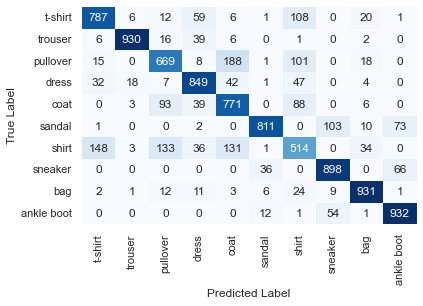

In [7]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(Y_test, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

---
### Exercise 2 (8 points)

Answer the following questions by studying the confusion matrix (above).

1. Which class has the lowest precision? What is that precision? Which class has the highest precision? What is that precision?   

2. For the class 'sneaker', what class is the largest source of false negatives? What about the largest source of false positives?
    

*Written answer:*

1. Lowest precision = shirts; precision = 514; Higest precision = ankle boot; precision = 932

2. Sneakers false negatives = sandals; sneaker false positives = 166

---

## Analyze Errors

A crucial part of the development cycle in Machine Learning is analyzing errors to help understand the shortcomings of the model. While typically we'd want to use the development data for this purpose to preserve the purity of the test set, we'll just use our test split for simplicity.

Since the "shirt" class seems to be the source for a lot of errors, let's look at some of the confusions.

---
### Exercise 3 (8 points)

1. Display 5 images with true label "shirt", but predicted label "coat" (false negatives for the "shirt" class).
2. Display 5 images with predicted label "shirt", but true label "coat" (false positives for the "shirt" class).

Shirts that where predictions to be coats:


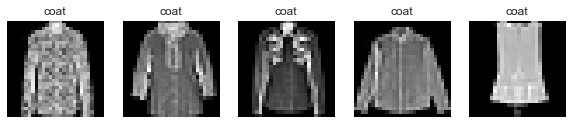

Coats that where predictions to be shirts:


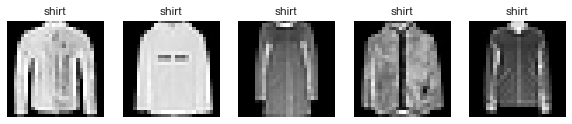

In [60]:
# YOUR CODE HERE

# model_graph = model.predict(X_test)
# test_predictions = np.argmax(model.predict(X_test), axis=-1)

# find shirt images with coat label
# confusion_matrix = tf.math.confusion_matrix(Y_test, test_predictions)

# print(test_predictions) # model predictions
# ax.set(xlabel='Predicted Label', ylabel='True Label')
# print(Y_test.shape) # true labels

# print(model_graph.shape)

# print(confusion_matrix)

# label_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
#                'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10,5))
# for i in range(5):
#   image = X_test[i]
#   label = Y_test[i]
#   label_name = label_names[label]
#   axs[i].imshow(image, cmap='gray')
#   axs[i].set_title(label_name)
#   axs[i].axis('off')
# plt.show()

img_arr_shirts = []
counter = 0
index = 0

print("Shirts that where predictions to be coats:")
while (counter < 5):
           
      # print(test_predictions[counter])
      # find shirt and coat labels
      if (
        Y_test[index] == 6 # true label = shirt
        and 
        test_predictions[index] == 4 # predict label = coat
        ):
            # print("counter = ", counter)
            counter += 1
            img_arr_shirts.append(X_test[index])
      
      # print("index = ", index)
      index += 1
      
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10,5))
for i in range(5):
  image = img_arr_shirts[i]
  label = test_predictions[6]
  label_name = label_names[label]
  axs[i].imshow(image, cmap='gray')
  axs[i].set_title(label_name)
  axs[i].axis('off')
plt.show()

img_arr_shirts = []
counter = 0
index = 0

print("Coats that where predictions to be shirts:")
while (counter < 5):
           
      # print(test_predictions[counter])
      # find shirt and coat labels
      if (
        Y_test[index] == 4 # true label = coat
        and 
        test_predictions[index] == 6 # predict label = shirt
        ):
            # print("counter = ", counter)
            counter += 1
            img_arr_shirts.append(X_test[index])
      
      # print("index = ", index)
      index += 1
      
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10,5))
for i in range(5):
  image = img_arr_shirts[i]
  label = test_predictions[4]
  label_name = label_names[label]
  axs[i].imshow(image, cmap='gray')
  axs[i].set_title(label_name)
  axs[i].axis('off')
plt.show()


           



---

## Visualize Parameters
Finally, here's some code that helps visualize the learned parameters for each class.

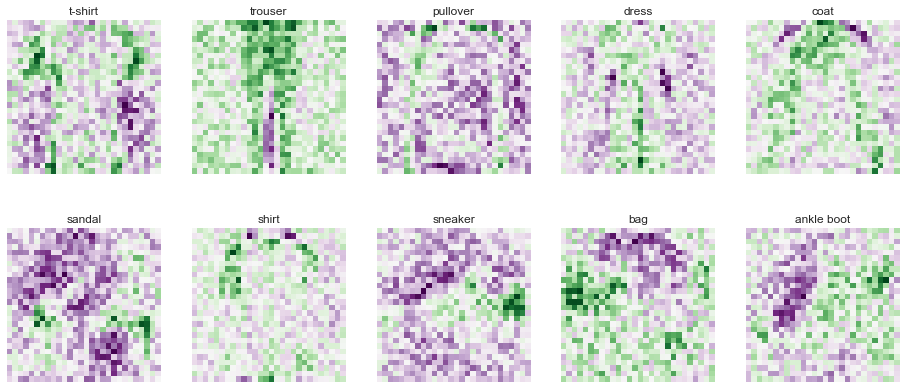

In [9]:
weights, biases = model.layers[1].get_weights()
fig, axs = plt.subplots(2, 5, figsize=(16,7))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(weights[:,i].reshape(28,28), cmap='PRGn')
  ax.axis('off')
  ax.set_title(label_names[i])
plt.show()